# 1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
!pip list

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'data' 

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 374 files belonging to 2 classes.


In [10]:
#Get another batch from the iterator if you rerun it
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

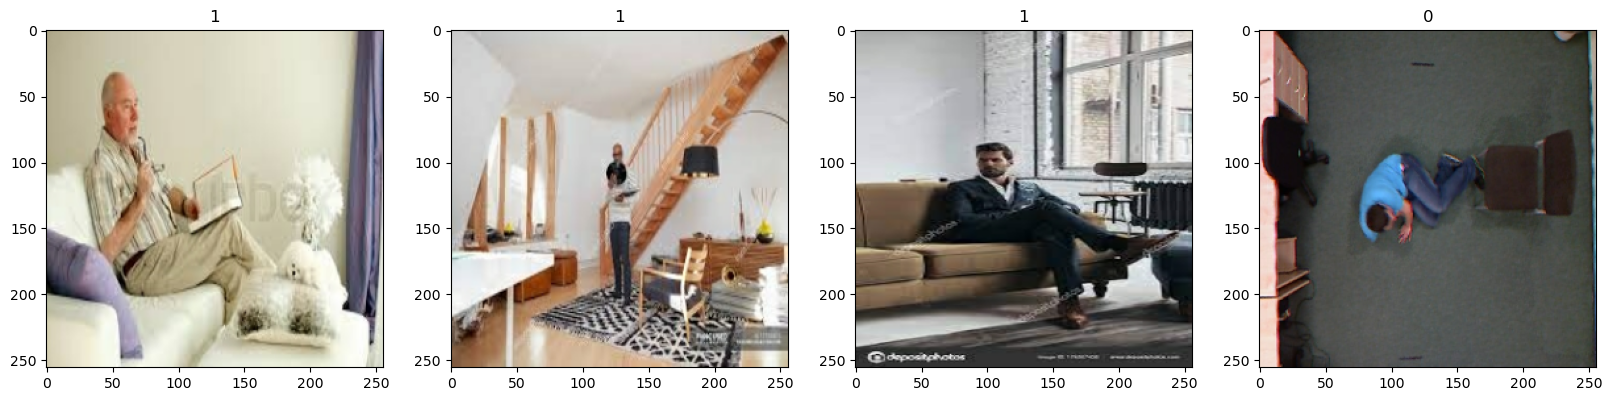

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [13]:
#Tensorflow tf dataset map function is used. data.map actually allows you to perform that transformation in pipeline
#x as images and y as labels
#Divide image value to save time in deep learning
#We can't run this for each batch of data pipline, so we have to create another one to scale data
data = data.map(lambda x,y: (x/255, y))

In [14]:
data.as_numpy_iterator().next()

(array([[[[0.24705882, 0.2509804 , 0.26666668],
          [0.2518171 , 0.25573868, 0.27142495],
          [0.25882354, 0.2560968 , 0.27510723],
          ...,
          [0.3982381 , 0.39431652, 0.41452178],
          [0.397998  , 0.39407644, 0.41489446],
          [0.45625767, 0.4514323 , 0.48551625]],
 
         [[0.25022212, 0.2541437 , 0.26982996],
          [0.2524367 , 0.25635827, 0.27204454],
          [0.26286846, 0.26014173, 0.27915215],
          ...,
          [0.40538532, 0.40146375, 0.421669  ],
          [0.40305817, 0.3991366 , 0.4199546 ],
          [0.46289062, 0.45896906, 0.4903416 ]],
 
         [[0.25465658, 0.25857815, 0.27426443],
          [0.25882354, 0.2627451 , 0.2784314 ],
          [0.2640828 , 0.26619944, 0.2827882 ],
          ...,
          [0.4156543 , 0.41173273, 0.431938  ],
          [0.41865122, 0.41472965, 0.43554768],
          [0.47238052, 0.46845895, 0.4998315 ]],
 
         ...,
 
         [[0.20399763, 0.20399763, 0.20399763],
          [0.20761

# 5. Split Data

In [15]:
#Split Data into Training and Testing Partition. Validating our data and ensuring that model hasn't overfit
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1) #Post Training Deep Learning Model

In [16]:
train_size

8

In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [18]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [20]:
model = Sequential()

In [21]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [22]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [24]:
logdir='logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
8/8 [==============================] - 6s 614ms/step - loss: 0.8167 - accuracy: 0.5625 - val_loss: 0.6741 - val_accuracy: 0.5469
Epoch 2/20
8/8 [==============================] - 5s 542ms/step - loss: 0.6440 - accuracy: 0.6758 - val_loss: 0.5536 - val_accuracy: 0.6875
Epoch 3/20
8/8 [==============================] - 5s 538ms/step - loss: 0.5347 - accuracy: 0.7344 - val_loss: 0.4247 - val_accuracy: 0.7812
Epoch 4/20
8/8 [==============================] - 5s 525ms/step - loss: 0.4798 - accuracy: 0.7461 - val_loss: 0.2936 - val_accuracy: 0.9375
Epoch 5/20
8/8 [==============================] - 4s 524ms/step - loss: 0.4215 - accuracy: 0.8320 - val_loss: 0.3070 - val_accuracy: 0.9062
Epoch 6/20
8/8 [==============================] - 5s 532ms/step - loss: 0.2871 - accuracy: 0.8945 - val_loss: 0.2628 - val_accuracy: 0.8750
Epoch 7/20
8/8 [==============================] - 5s 551ms/step - loss: 0.2290 - accuracy: 0.9258 - val_loss: 0.1548 - val_accuracy: 0.9531
Epoch 8/20
8/8 [====

# 8. Plot Performance

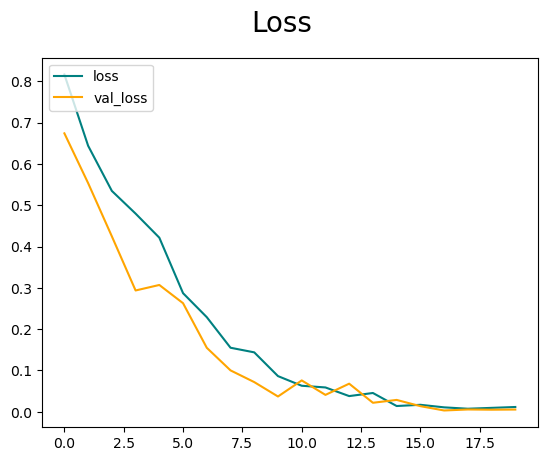

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

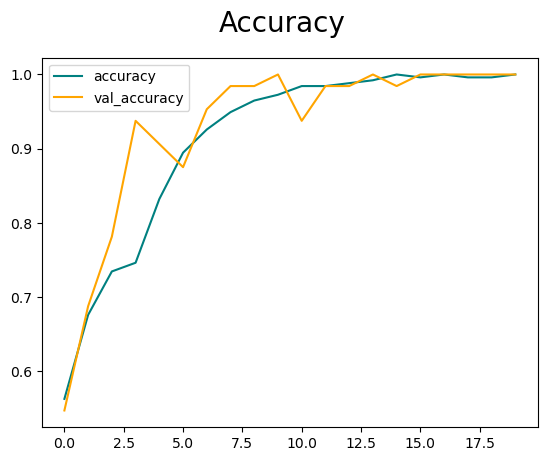

In [28]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [29]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [30]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [31]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 190ms/step


In [32]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [33]:
import cv2

In [ ]:
#Testing data outside of the dataset. To test out the image that model has never seen before.

img=cv2.imread('2.jpg') #input random image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #opencv always read image in BGR.
plt.show()

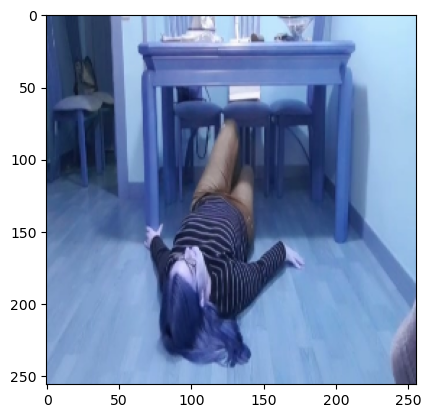

In [35]:
#When we pass data into neural network, the image need to be in shape (256,256) pixels also need to be 3 channel

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [36]:
#The reason why we are doing this prediction is, neural network expects us to pass through a batch of images not a single image, so need to encapsulate
#inside of another set of parentheses or array
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 74ms/step


In [37]:
yhat

array([[0.9994181]], dtype=float32)

In [38]:
if yhat > 0.5: 
    print(f'Predicted class is Fall')
else:
    print(f'Predicted class is Not Fall')

Predicted class is Fall


# 11. Save the Model

In [50]:
from tensorflow.keras.models import load_model

In [51]:
model.save(os.path.join('models','imageclassifierforFallorNotFall.h5'))

In [53]:
new_model = load_model(os.path.join('models','imageclassifierforFallorNotFall.h5'))

In [54]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 101ms/step


array([[0.9994181]], dtype=float32)